In [16]:
import matplotlib.pyplot as plt
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from itertools import combinations, product
from tqdm import tqdm  # progress bar

In [17]:
# import data
allTrain = pd.read_csv('D:/notebooks/coursework/dataset/train.csv')
n = len(allTrain)
X_train = allTrain.drop('label', 1).to_numpy()
Y_train = allTrain['label'].to_numpy()
del allTrain
test = pd.read_csv('D:/notebooks/coursework/dataset/test.csv')
X_test = test.to_numpy()
print("data import complete")

C:\Users\ALEX\AppData\Local\Temp\ipykernel_25916\1560496564.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train = allTrain.drop('label', 1).to_numpy()


data import complete


In [18]:
class HopfieldNetwork(object):
    def __init__(self, pattern, rule='pseudo-inverse'):
        '''expects patterns to have values belonging to {-1, 1}
           initializes with Hebbian rule'''
        self.n = pattern[0].size
        self.order = np.arange(self.n)

        if rule == 'hebbian':
            self.w = np.tensordot(pattern, pattern, axes=((0), (0))) / len(pattern)
            self.w[self.order, self.order] = 0.0
        elif rule == 'pseudo-inverse':
            c = np.tensordot(pattern, pattern, axes=((1), (1))) / len(pattern)
            cinv = np.linalg.inv(c)
            self.w = np.zeros((self.n, self.n))
            for k, l in product(range(len(pattern)), range(len(pattern))):
                self.w = self.w + cinv[k, l] * pattern[k] * pattern[l].reshape((-1, 1))
            self.w = self.w / len(pattern)
        else:
            assert False, 'invalid learning rule: {}\nplease choose hebbian or pseudo-inverse'.format(rule)

    def processBatch(self, x, iters=30):
        '''input should be same size format as patterns. Implements asynchronous update'''
        h = np.array(x, dtype=float)
        for _ in range(iters):
            np.random.shuffle(self.order)
            for i in self.order:
                h[:, i] = np.tensordot(self.w[i], h, axes=((-1), (-1)))
                h[:, i] = np.where(h[:, i] < 0, -1.0, 1.0)
        return h


class HopfieldForest(object):
    '''Because expressiveness is so limited
       use multiple nets for different sets of patterns'''

    def __init__(self, pattern, perSet=2):
        '''expects patterns to have values belonging to {-1, 1}
           initializes with Hebbian rule'''
        self.net = [HopfieldNetwork(p) for p in combinations(pattern, perSet)]

    def processBatch(self, x, iters=4):
        '''input should be same size format as patterns. Implements asynchronous update
        returns the results from all models stacked together'''
        return np.array([n.processBatch(x) for n in self.net])

100%|██████████| 8/8 [00:00<00:00, 7979.65it/s]


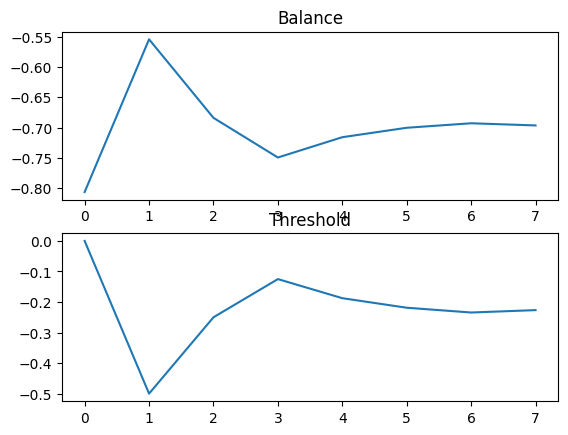

In [19]:
# create patterns
supervised = True
factor = 2.0 / np.max(X_train)
avg_classes = lambda: np.array([factor * np.mean(X_train[Y_train == l, :], axis=0) - 1.0
                                for l in np.unique(Y_train)])
patterns = avg_classes() if supervised else (factor * X_train - 1)

# convert to bitwise
low = -1.0
high = 1.0
iters = 8
metric = np.zeros(iters)
threshold = np.zeros(iters)
for i in tqdm(range(iters)):
    threshold[i] = (low + high) / 2
    metric[i] = np.mean(np.where(patterns < threshold[i], -1, 1))
    if metric[i] > -0.7:  # 0.7 chosen by inspection
        low = threshold[i]
    else:
        high = threshold[i]
bitPatterns = np.where(patterns < threshold[-1], -1, 1)
XB_train = np.where((factor * X_train - 1) < threshold[-1], -1, 1) if supervised else bitPatterns
XB_test = np.where((factor * X_test - 1) < threshold[-1], -1, 1)

plt.subplot(211)
plt.title('Balance')
plt.plot(metric)
plt.subplot(212)
plt.title('Threshold')
plt.plot(threshold)

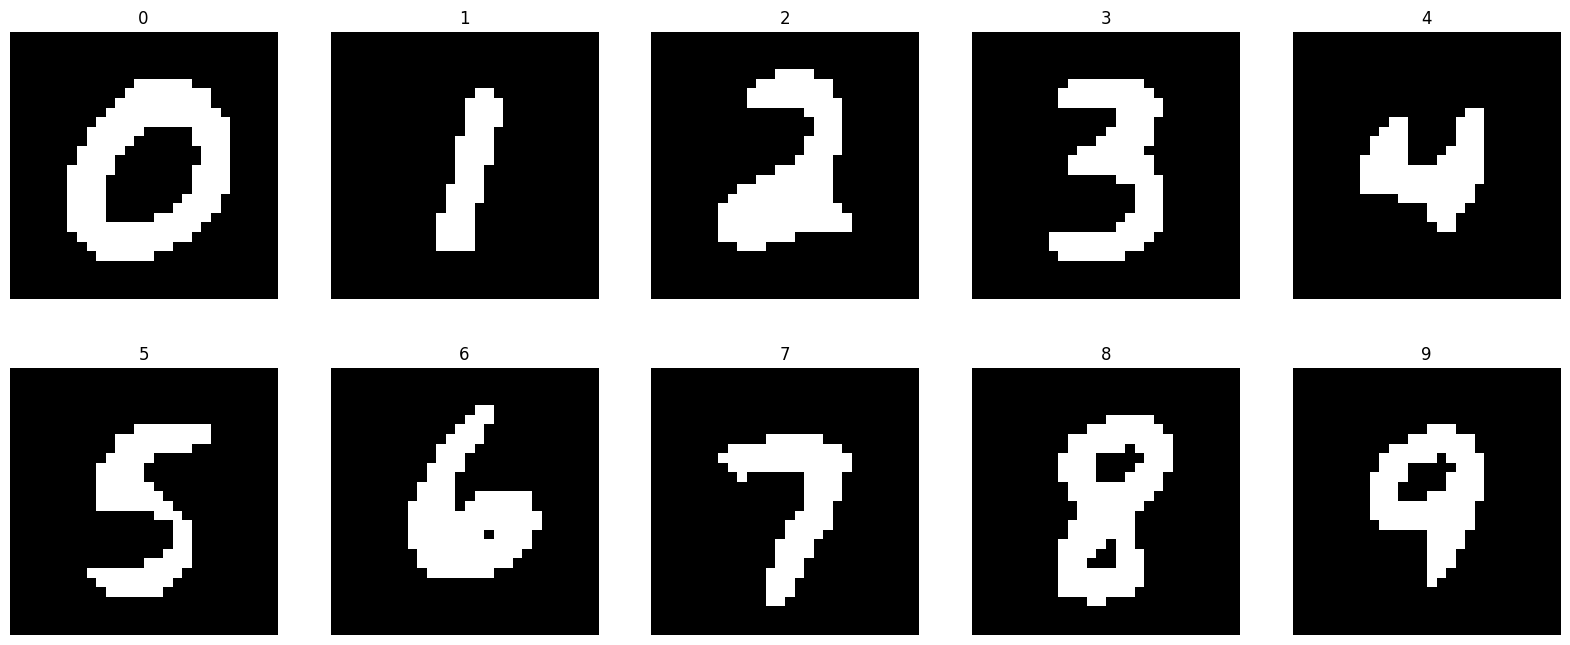

In [20]:
#peek at patterns
plt.figure(figsize=[20, 8])
for i in range(min(len(bitPatterns), 10)):
    plt.subplot(2, 5, i + 1)
    plt.title(i if supervised else Y_train[i])
    plt.axis('off')
    plt.imshow(bitPatterns[i].reshape((28, 28)), cmap='gray')

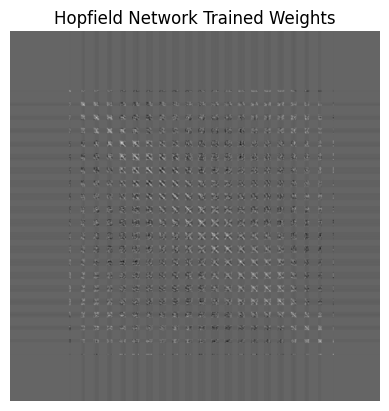

In [21]:
# create and train hopfield networks (one for each pair, because expressiveness sucketh)
hopnet = HopfieldNetwork(bitPatterns)

# view weight matrix
plt.title('Hopfield Network Trained Weights')
plt.axis('off')
plt.imshow(hopnet.w, cmap='gray')
pass

In [22]:
XH_train = hopnet.processBatch(XB_train)
XH_test = hopnet.processBatch(XB_test)

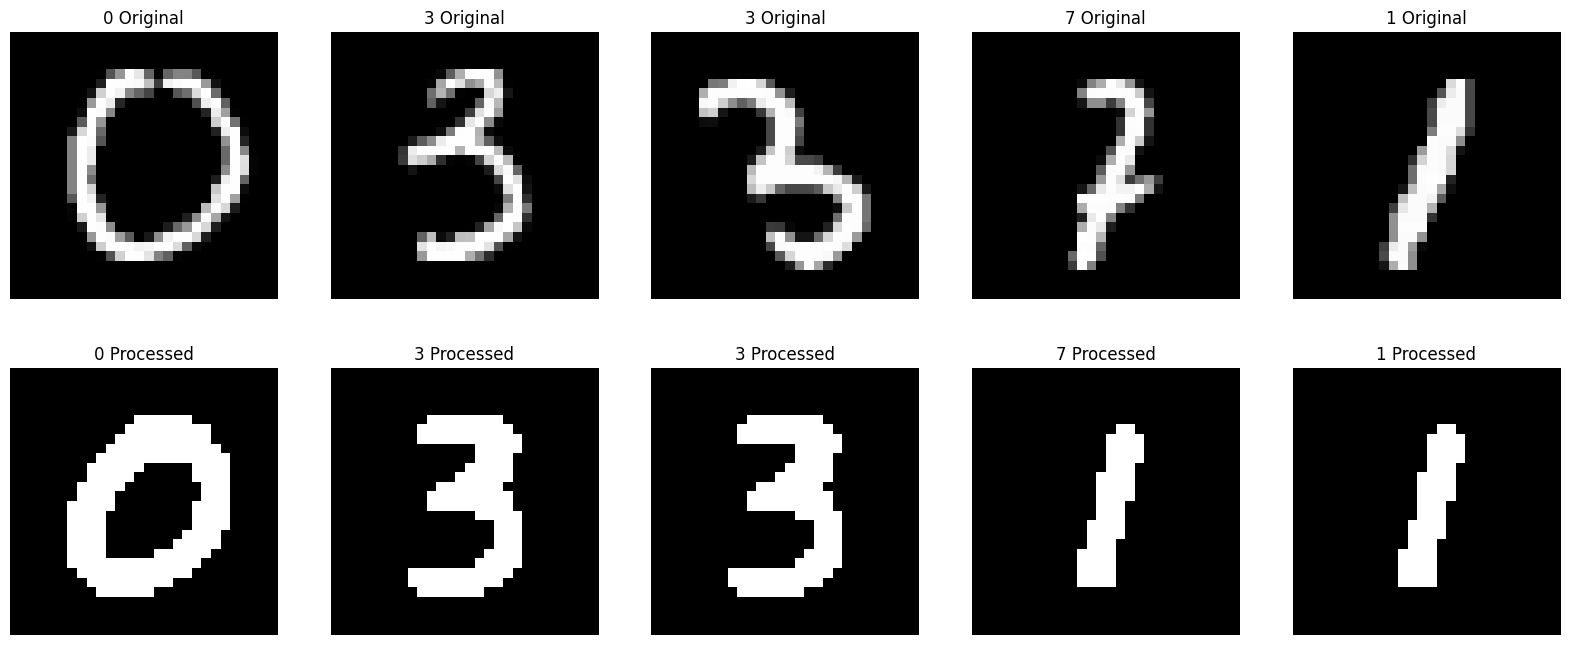

In [23]:
plt.figure(figsize=[20, 8])
for i, c in enumerate(np.random.choice(len(XH_train), 5, False)):
    l = Y_train[c]

    # original image
    plt.subplot(2, 5, i + 1)
    plt.title("{} Original".format(l))
    plt.axis('off')
    plt.imshow(X_train[c].reshape((28, 28)), cmap='gray')

    # processed image
    plt.subplot(2, 5, i + 6)
    plt.title("{} Processed".format(l))
    plt.axis('off')
    plt.imshow(XH_train[c].reshape((28, 28)), cmap='gray')

In [24]:
from scipy.spatial import distance


def determineLabel(x):
    leastDistance = 100
    label = 0
    for lbl, b in enumerate(bitPatterns):
        dst = distance.euclidean(x, b)
        if (dst < leastDistance):
            leastDistance = dst
            label = lbl
    return label


def getLabelByLeastRange(X):
    return np.array([determineLabel(x) for x in X])


In [25]:
from sklearn.metrics import classification_report

print(classification_report(Y_train, getLabelByLeastRange(XH_train)))

              precision    recall  f1-score   support

           0       0.94      0.71      0.81      4132
           1       0.47      0.98      0.64      4684
           2       0.86      0.53      0.66      4177
           3       0.69      0.66      0.68      4351
           4       0.75      0.68      0.71      4072
           5       0.52      0.53      0.53      3795
           6       0.79      0.69      0.74      4137
           7       0.72      0.82      0.77      4401
           8       0.80      0.54      0.65      4063
           9       0.70      0.58      0.64      4188

    accuracy                           0.68     42000
   macro avg       0.73      0.67      0.68     42000
weighted avg       0.72      0.68      0.68     42000



Distorted dataset

In [26]:
from scipy.stats import bernoulli as bn


# noise determines how many pixels will be replaced

def distort(x, noise=0.1):
    array = x.copy()
    flag = bn.rvs(p=noise, size=(len(x)))
    array[flag == 1] = -array[flag == 1]
    return array



In [27]:
D_X = np.array([distort(x) for x in XB_train])

In [28]:
XD_train = hopnet.processBatch(D_X, iters=100)

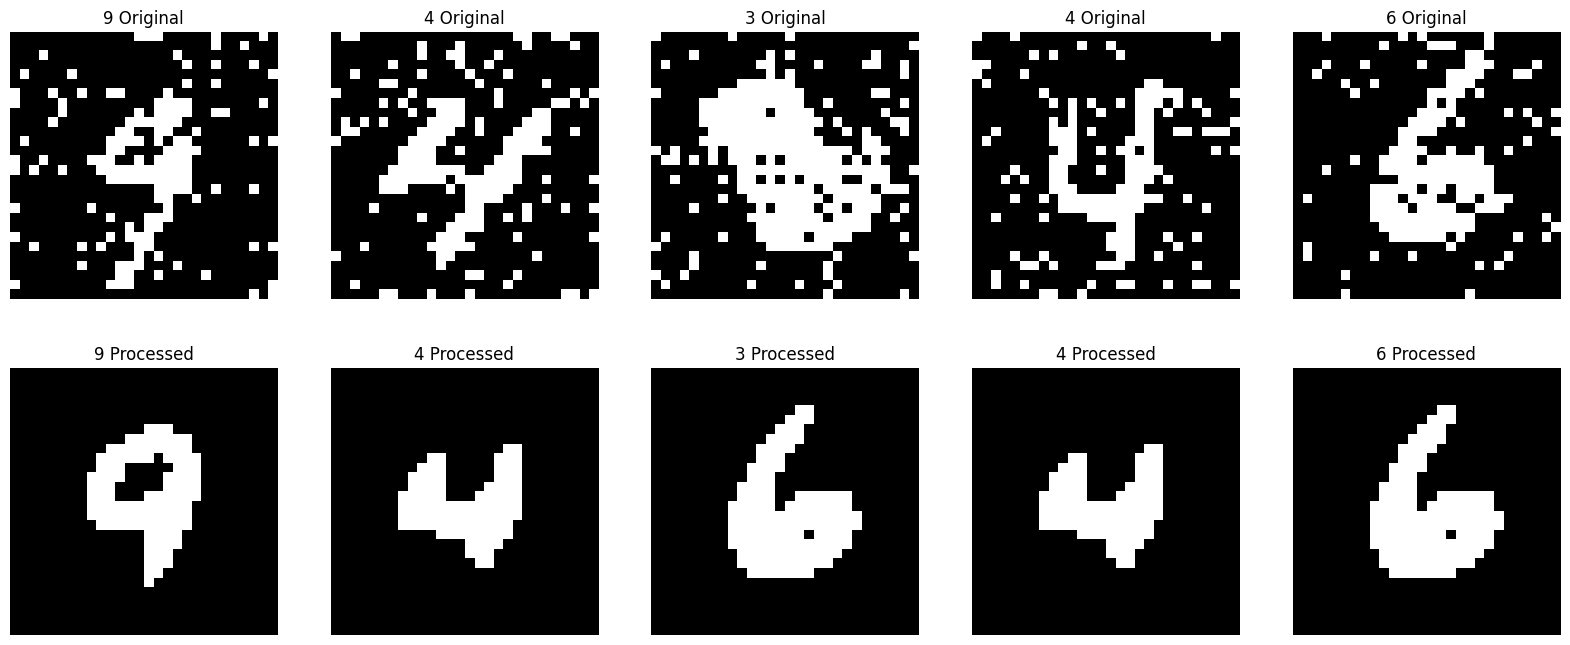

In [33]:
plt.figure(figsize=[20, 8])
for i, c in enumerate(np.random.choice(len(D_X), 5, False)):
    l = Y_train[c]

    # original image
    plt.subplot(2, 5, i + 1)
    plt.title("{} Original".format(l))
    plt.axis('off')
    plt.imshow(D_X[c].reshape((28, 28)), cmap='gray')

    # processed image
    plt.subplot(2, 5, i + 6)
    plt.title("{} Processed".format(l))
    plt.axis('off')
    plt.imshow(XD_train[c].reshape((28, 28)), cmap='gray')

In [30]:
print(classification_report(Y_train, getLabelByLeastRange(XD_train)))

              precision    recall  f1-score   support

           0       0.94      0.67      0.78      4132
           1       0.46      0.98      0.63      4684
           2       0.83      0.56      0.67      4177
           3       0.70      0.63      0.67      4351
           4       0.71      0.62      0.66      4072
           5       0.51      0.53      0.52      3795
           6       0.77      0.65      0.70      4137
           7       0.75      0.76      0.76      4401
           8       0.80      0.51      0.62      4063
           9       0.60      0.62      0.61      4188

    accuracy                           0.66     42000
   macro avg       0.71      0.65      0.66     42000
weighted avg       0.71      0.66      0.66     42000

